## Working with Multiple Hypotheses

In many applications of geostatistics, evaluation of multiple hypotheses may be warranted. In the context of spatial autocorrelation for example, one might test the null hypothesis that the analysis variable for a feature is randomly distributed among features in its neighborhood (i.e. one hypothesis per feature). In such cases, there is always some probability that a significant outcome could arise just due to chance. Specifically, given a set of h hypotheses, a desired confidence level alpha and the associated significance level lambda=(1-alpha), the probability of at least one significant outcome (s) being realized simply due to chance is P(s)=(1-(1-lambda)^h).

Consider this example, given the testing of one hypothesis at a desired confidence level of 0.90, the associated significance level that is sought is 0.10. Thus, the probability of no significant outcome arising is 0.90 and the probability of at least one significant outcome being realized due to chance is (1-(1-0.10)^1) = 0.10, which is what we were expecting.  However, if testing of three hypotheses (h=3) is required, then the probability of at least one significant outcome arising due to chance becomes (1-(1-0.10^3))=0.142. In other words, as the number of hypotheses involved increase, then there is a larger probability that one might observe a significant outcome just due to chance alone!

So what? Well, if there is a larger probability that a significant outcome will arise simply due to chance, then something must be done to account for that happening. One way to cope with this increased probability is to make some sort of adjustment to the confidence levels in order to help avoid getting an erroneous significant outcome. In other words, the confidence levels can be made more restrictive.

To illustrate how the confidence levels can be adjusted to account for multiple hypotheses, let's first consider an example dataset, retrieve an analysis variable, and visualize the distribution of the variable.

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','repr')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){
           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'rgdal' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'spdep' was built under R version 3.4.2"Warning message:
"package 'classInt' was built under R version 3.4.2"

## Analysis of Cancer Incidence Rates

Let's work with the New York Cancer Registry dataset. Details regarding this registry can be found at(https://www.health.ny.gov/statistics/cancer/registry/Read).  

We will be working with incidence of prostate cancer as summarized at the zip code level (https://www.health.ny.gov/statistics/cancer/registry/zipcode/index.htm). 

In [2]:
#Read in the featureclass
inFeatures <- readOGR("datasets/newyork_cancer","NYzipUTM")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/newyork_cancer", layer: "NYzipUTM"
with 1384 features
It has 8 fields
Integer64 fields read as strings:  PRIMARY ObsIncid 


In [3]:
peek <- head(inFeatures@data)

peek

,PRIMARY,COUNT,MalePop,ObsIncid,CRate,test,CRate2,crate3
0,0,3,0,0,0.000000000,0,NA,NA
1,10001,1,9570,54,0.005642633,0,0.00564263,0.00564263
2,10002,1,37830,190,0.005022469,0,0.00502247,0.00502247
3,10003,1,25524,160,0.006268610,0,0.00626861,0.00626861
4,10005,3,2283,9,0.003942181,0,0.00394218,0.00394218
5,10007,1,5256,13,0.002473364,0,0.00247336,0.00247336


## Defining Neighborhoods

The first step is to define neighborhoods for each feature (zip code areas in this case)

In [4]:
#Identify the neighbors of each feature
inFeatures.nb <- poly2nb(inFeatures,queen=TRUE)

In [5]:
inFeatures.nb[1:10]

[[1]]
 [1]  14  16  17  18  19  20  21  22  24  25  32  38 256 257 258

[[2]]
[1]  8  9 13 15

[[3]]
[1]  4  7  8 10 11 34

[[4]]
[1]  3  7  8  9 10

[[5]]
[1]  6 34 39

[[6]]
[1]  5 11 34 39

[[7]]
[1] 3 4 8

[[8]]
[1]  2  3  4  7  9 13

[[9]]
[1]  2  4  8 10 12

[[10]]
[1]  3  4  9 11 12

## Validating Inputs

Again, it is good to check the neighborhoods for features and only retain those features that have a valid neighborhood. To do this, the cardinality (number of elements in a set) of each neighborhood is first examined using the card() function (spdep library). Next, only those features with at least a cardinality of one (one neighbor) are selected. The Queen's criterion is applied and then neighborhoods are transformed into lists.

In [6]:
card(inFeatures.nb)[1:10] 

[1] 15  4  6  5  3  4  3  6  5  5

In [7]:
#Select features with at least one neighbor
inFeaturesSubset <- inFeatures[card(inFeatures.nb) >= 1, ]
length(inFeaturesSubset)

[1] 1381

In [8]:
#Identify the neighbors of each feature having at least one neighbor
inFeaturesSubset.nb <- poly2nb(inFeaturesSubset, queen=TRUE)

In [9]:
inFeaturesSubset.nb[1:10]

[[1]]
 [1]  14  16  17  18  19  20  21  22  24  25  32  37 255 256 257

[[2]]
[1]  8  9 13 15

[[3]]
[1]  4  7  8 10 11 34

[[4]]
[1]  3  7  8  9 10

[[5]]
[1]  6 34 38

[[6]]
[1]  5 11 34 38

[[7]]
[1] 3 4 8

[[8]]
[1]  2  3  4  7  9 13

[[9]]
[1]  2  4  8 10 12

[[10]]
[1]  3  4  9 11 12

In [10]:
#Retrieve neighborhood list
inFeaturesSubset.listb <- nb2listw(inFeaturesSubset.nb, style = "B")
inFeaturesSubset.listw <- nb2listw(inFeaturesSubset.nb, style = "W")

In [11]:
names(inFeaturesSubset.listb)

[1] "style"      "neighbours" "weights"

In [12]:
inFeaturesSubset.listb$weights[1:10]

[[1]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[2]]
[1] 1 1 1 1

[[3]]
[1] 1 1 1 1 1 1

[[4]]
[1] 1 1 1 1 1

[[5]]
[1] 1 1 1

[[6]]
[1] 1 1 1 1

[[7]]
[1] 1 1 1

[[8]]
[1] 1 1 1 1 1 1

[[9]]
[1] 1 1 1 1 1

[[10]]
[1] 1 1 1 1 1

## Feature Attribute to Analyze

In most assessments of spatial autocorrelation, some attribute of each feature is compared relative to that of it's neighbors. Therefore, let's select an attribute to analyze. Here, incidence rate over the population is examined. In this case, prostate cancer incidence 'ObsIncid' is taken relative to the male population 'MalePop'. Just to ensure that every feature can be associated with a rate (i.e. in the event that no population exists in an area), the rate variable is checked for Null and set to 0.0 if such instances exist.

In [15]:
#retrieve variables
inVa <- as.numeric(as.character(inFeaturesSubset$ObsIncid)) # prostate cancer incidence
inVb <- as.numeric(as.character(inFeaturesSubset$MalePop)) # male population

#incident rate variables
VarA <- (inVa/inVb)

#if a variable is Null/NaN, set to zero so there are no missing values
VarA[is.nan(VarA)] <- 0

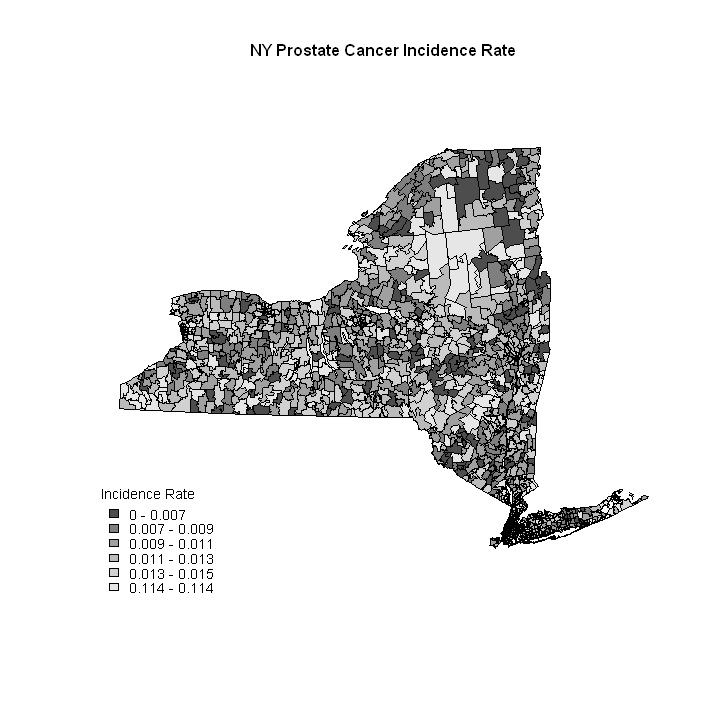

In [16]:
#classify variable
numcat <- 6

cate <- classIntervals(VarA,numcat,style="quantile")

#plot classified variable
pal1 <- gray.colors(numcat)

cols <- findColours(cate,pal1)

plot(inFeaturesSubset, col = cols, lwd = 0.2,
     main = "NY Prostate Cancer Incidence Rate", cex.main = 0.8)

brks <- round(cate$brks,3)

leg.text <- paste(brks[-numcat], brks[-1], sep=" - ")

legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text,
       bty = "n",title = "Incidence Rate",cex = 0.7)

## Configuration for multiple testing

If one were to run an analysis that resulted in a set of signficance values (p-values) for each observation, they typically (unless the implementation of the method provided for other distributional forms) would be considered 'uncorrected' or simply based on the normal distribution at this point. That is, they would not account for potential spatial dependencies and/or testing of alternative hypotheses. In many geostatistical approaches, the resulting p-values are used to evaluate significance, however, they alone do not provide information on the nature of the spatial relationship. As such, z-scores (standard scores or deviations) are used to provide greater insights into the nature of the spatial relationships. Thus, a linkage needs to be made between the significant p-values and the z-scores with which they are associated.  Let's take a look at the confidence levels associated with the normal distribution and their associated z-scores.

### Normally Distributed Data

Let's consider z-scores bounds at different confidence levels for the normal distribution. To do this, consider a vector of different confidence levels (named 'probsU' below)for which to identify corresponding z-scores. For each confidence level (i.e. 0.90, 0.95, 0.99, 0.995), the confidence level is then converted into a one tailed significance level. The significance probability is then input into the qnorm() function to return the quantile (z-scores) associated with that particular probability.

In [17]:
#Normal z-scores
#list of normal z-scores
zNormal <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95, 0.99, 0.995)

#compute higher levels
i <- 1
for (pr in probsU) {    
    #convert confidence levels to significance probs.
    inpr <- 1-((1-pr)/2)
    #compute normal error for z-score
    errorZ <- qnorm(inpr,lower.tail=TRUE)
    zNormal[[i]] <- 0 + errorZ    
    i <- i+1
}

In [18]:
zNormal

[[1]]
[1] 1.644854

[[2]]
[1] 1.959964

[[3]]
[1] 2.575829

[[4]]
[1] 2.807034

In [19]:
zM <- unlist(zNormal)

In [20]:
zM

[1] 1.644854 1.959964 2.575829 2.807034

In [21]:
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU, zM, sep = "   ")

[1] "0.9   1.64485362695147"   "0.95   1.95996398454005" 
[3] "0.99   2.5758293035489"   "0.995   2.80703376834381"

## Effective Sample Size

Should spatial dependence among the features be assumed to exist, then the distributional qualities evaluated need to be altered to reflect these dependencies. One way to do this is to consider what's known as the effective sample size (ESS): the number of samples that are likely required in order to realize a significant outcome. In other words, given that spatial autocorrelation is thought to exist, ESS is the number of independent samples that would be needed to represent the sampling size of a spatially autocorrelated dataset.  For example, the number of observations in the zip code dataset is 1381 (after the areas with no neighbors were eliminated). Assuming these are perfectly autocorrelated observations, then only one sample is needed to detect spatial autocorrelation. This is what is assumed in the 'uncorrected' normally distributed z-scores described previously. However, in instances where spatial autocorrelation may not be 'perfect', a greater number of samples would be required - i.e. ESS would higher.

Griffith (2005) suggests that one way to derive ESS for a spatial dataset is to run a spatial simultaneous autoregressive error model estimation on the analysis variable relative to it's neighborhood to gauge the extent of spatial dependence (spoiler alert - this will covered in more detail in a later module). The spatial autocorrelation coefficient (rho) can then be retrieved and used to calculate estimated sample size per the equation of Griffith (2005). Here, the spatial simultaneous autoregressive error model is computed using the errorsarlm() function (spdep library). The ESS calculated below is 667.844, meaning that ~667 random samples would be needed to detect significant spatial autocorrelation in this dataset.  As you could observe by manually varying the ESS, the larger the ESS, the more constrictive the z-scores become. 

Griffith, D.A. (2005) Effective geographic sample size in the presence of spatial autocorrelation. Annals of the Association of American Geographers. 95(4). Available online through the MU library.

In [22]:
#Compute effective sample size
feat.d.sar <- errorsarlm(VarA ~1, listw = inFeaturesSubset.listw)

feat.d.sar


Call:
errorsarlm(formula = VarA ~ 1, listw = inFeaturesSubset.listw)
Type: error 

Coefficients:
     lambda (Intercept) 
 0.32810449  0.01167451 

Log likelihood: 5027.743 

In [23]:
rho <- feat.d.sar$lambda

rho

lambda 
0.3281045

In [24]:
rho2 <- unname(rho)

rho2

[1] 0.3281045

In [25]:
#compute set size of observed z-score distribution
dvalues <- length(inFeaturesSubset)

dvalues

[1] 1381

In [26]:
#Calculated effective sample size per Griffith's (2005) eq.
ESS <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2) + (.20024*sqrt(rho2)))))

ESS

[1] 667.844

In [27]:
paste("ESS =", ESS, sep = " ")

[1] "ESS = 667.844040743148"

### Other Adjustments

Instead of simply evaluating a hypothesis based on the uncorrected p-values, we can now adjust the p-value given what is known about the ESS for the dataset.  Let's examine several other ways to adjust the interpretation of the z-scores: a) adjusted normal dist, b) t-statistic adjusted, c) Bonferroni adjustment, etc.

### Adjusted normal distribution

The original confidence level can be adjusted for a normal distribution using the ESS. The the qnorm() function can be applied to obtain the quantiles (z-scores) associated with each confidence level given the ESS is used to adjust the significance levels.

In [28]:
#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95, 0.99, 0.995)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(VarA)
    newpr <- 1-(((1-pr)/ESS)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

zcM <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,zcM,sep="   ")

[1] "0.9   3.80313915404991"   "0.95   3.97189289753463" 
[3] "0.99   4.34070857078138"  "0.995   4.49098981897933"

### t-distribution

For the t-distribution, the original confidence level can be adjusted using the ESS. The the qt() function can be applied to return the quantiles (z-scores) of the t-distribution associated with the significance values given the ESS is used to adjust the significance values and the degrees of freedom in the dataset.

In [29]:
#list of adjusted t statistic z-score breakpts
zTStatAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95, 0.99, 0.995)

#compute higher levels
i <- 1
for (pr in probsU) {       
    #modify the probability to account for ESS
    newpr <- 1-(((1-pr)/ESS)/2)
    
    #compute error for t-statistic    
    errorT <- qt(newpr,df=ESS-2,lower.tail = TRUE) 
    zTStatAdjusted[[i]] <- 0 + errorT
    
    i <- i+1
}

tcM <- unlist(zTStatAdjusted)

#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,tcM,sep="   ")

[1] "0.9   3.81350902899451"   "0.95   3.9852074973756"  
[3] "0.99   4.36137453803379"  "0.995   4.51503276883661"

### Bonferroni Correction

The original confidence level can be adjusted using a Bonferroni Correction. The Bonferroni correction adjusts the significance levels relative to the number of elements in the dataset.  The the qnorm() function can then be applied to return the quantiles (z-scores) given the adjusted significance values.


In [30]:
#list of bonferroni corrected z-score breakpts
zBNAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95, 0.99, 0.995)

#compute set size of observed z-score distribution
dval <- length(inFeaturesSubset)

#compute higher levels
i <- 1
for (pr in probsU) {
    
    #compute error according to bonferonni adjustment
    berpr <- 1-(((1-pr)/dval)/2)
    errorBN <- qnorm(berpr,lower.tail=TRUE)
    zBNAdjusted[[i]] <- 0 + errorBN
    
    i <- i+1
}

bfcM <- unlist(zBNAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,bfcM,sep="   ")

[1] "0.9   3.96822057594178"   "0.95   4.13044832063272" 
[3] "0.99   4.48647474486686"  "0.995   4.63205354443898"